# Establishing baseline, beating the baseline, and model that overfits

---

### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, utils
from tensorflow import keras
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '../helpers/')
from plot_graphs import plot_loss, plot_acc

## 1. Establishing the baseline and importing datasets

----

Baseline accuracy is 1/6 or 16.67%

----

### 1.1 Setting Batch and Image size

In [2]:
IMAGE_SIZE = 100
BATCH_SIZE = 32

### 1.2 Loading the train val and test data

In [3]:
# Getting train, validation, and test data

train = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/train", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
val = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/val", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
test = utils.image_dataset_from_directory("../datasets/data/split/Zenodo/test", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

# Caching the datasets to load faster
train = train.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
val = val.prefetch(buffer_size=tf.data.AUTOTUNE).cache()
test = test.prefetch(buffer_size=tf.data.AUTOTUNE).cache()

Found 3840 files belonging to 6 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 480 files belonging to 6 classes.
Found 480 files belonging to 6 classes.


2022-08-28 23:53:53.950716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-28 23:53:53.950892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 2. Small model to beat baseline

> This is a relatively small model with only three Conv2D layers that runs for 10 epochs, and its only purpose is to beat the baseline accuracy of 16.67%.

### 2.1 Defining and running the model

In [33]:
# Defining the model
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_baseline = keras.Model(inputs, outputs)

# Compiling the model
model_baseline.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Printing model summary
model_baseline.summary()

# Training the model
history_baseline = model_baseline.fit(
  train,
  epochs=10,
  validation_data=val
)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                     

2022-08-30 23:03:40.981993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.7310 - accuracy: 0.2471

2022-08-30 23:03:44.421477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 4s 27ms/step - loss: 1.7310 - accuracy: 0.2471 - val_loss: 1.6715 - val_accuracy: 0.2083
Epoch 2/10
120/120 [==============================] - 3s 23ms/step - loss: 1.5637 - accuracy: 0.3719 - val_loss: 1.5878 - val_accuracy: 0.2854
Epoch 3/10
120/120 [==============================] - 3s 23ms/step - loss: 1.4220 - accuracy: 0.4484 - val_loss: 1.2875 - val_accuracy: 0.5188
Epoch 4/10
120/120 [==============================] - 3s 23ms/step - loss: 1.3137 - accuracy: 0.5026 - val_loss: 1.2128 - val_accuracy: 0.5417
Epoch 5/10
120/120 [==============================] - 3s 23ms/step - loss: 1.2326 - accuracy: 0.5349 - val_loss: 1.1568 - val_accuracy: 0.5458
Epoch 6/10
120/120 [==============================] - 3s 23ms/step - loss: 1.1708 - accuracy: 0.5539 - val_loss: 1.1333 - val_accuracy: 0.5458
Epoch 7/10
120/120 [==============================] - 3s 24ms/step - loss: 1.1291 - accuracy: 0.5664 - val_loss: 1.0729 - val_accuracy: 0.5646
Epoch 8/10

### 2.2 Plotting graphs

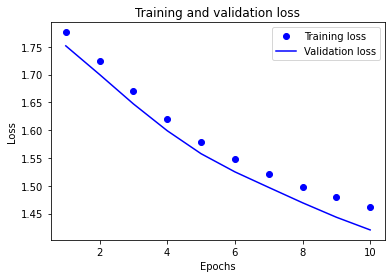

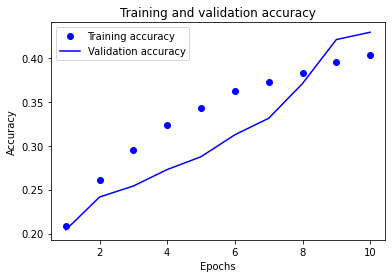

In [31]:
# Plotting the loss and accuracy
plot_loss(history_baseline)
plot_acc(history_baseline)

> As can be seen from the validation accuracies outputs and training and validation accuracy graph above, the models starts at about 20% accuracy, and reaches around 60% by the 10th epoch, definitely beating the baseline of 16.67% as intended.

---

*Highest Observed Validation Accuracy*: **60.21%**

---

## 3. Scaling up: a model that overfits

> In this model, we will add more layers, make the layers bigger, and train for more epochs. The purpose here is to build a model that overfits. 

### 3.1 Defining and training the model

In [27]:
inputs = keras.Input(shape=(100, 100, 3))
x = inputs
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(6, activation='softmax')(x)

model_overfitting = keras.Model(inputs, outputs)

model_overfitting.compile(optimizer=keras.optimizers.RMSprop(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_overfitting.summary()

history_overfitting = model_overfitting.fit(
  train,
  epochs=60,
  validation_data=val
)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling_8 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                      

2022-08-30 04:59:48.014778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


119/120 [============================>.] - ETA: 0s - loss: 1.7219 - accuracy: 0.2458

2022-08-30 04:59:52.235480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 5s 34ms/step - loss: 1.7192 - accuracy: 0.2477 - val_loss: 1.5384 - val_accuracy: 0.3771
Epoch 2/60
120/120 [==============================] - 4s 32ms/step - loss: 1.3892 - accuracy: 0.4669 - val_loss: 1.1843 - val_accuracy: 0.5604
Epoch 3/60
120/120 [==============================] - 4s 33ms/step - loss: 1.1673 - accuracy: 0.5719 - val_loss: 0.9528 - val_accuracy: 0.6792
Epoch 4/60
120/120 [==============================] - 4s 31ms/step - loss: 1.0380 - accuracy: 0.6221 - val_loss: 0.8408 - val_accuracy: 0.7063
Epoch 5/60
120/120 [==============================] - 4s 31ms/step - loss: 0.9486 - accuracy: 0.6495 - val_loss: 0.7579 - val_accuracy: 0.7333
Epoch 6/60
120/120 [==============================] - 4s 33ms/step - loss: 0.8745 - accuracy: 0.6779 - val_loss: 0.6941 - val_accuracy: 0.7521
Epoch 7/60
120/120 [==============================] - 4s 31ms/step - loss: 0.8088 - accuracy: 0.7052 - val_loss: 0.6283 - val_accuracy: 0.7750
Epoch 8/60

### 3.2 Plotting graphs

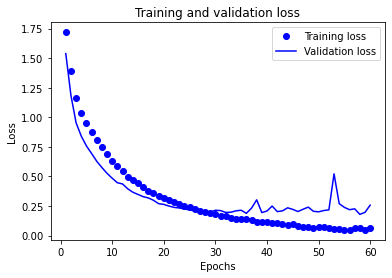

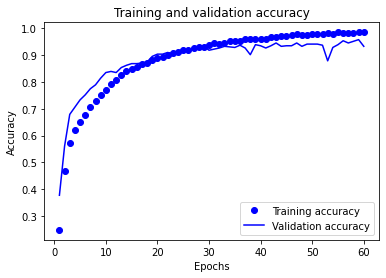

In [32]:
# Plotting the loss and accuracy
plot_loss(history_overfitting)
plot_acc(history_overfitting)

> Observing the training and validation accuracy graph above, it can be seen that the validation accuracy starts to diverge from the training accuracy after about the 35th epoch, and the model degrades from there. This shows that overfitting is now achieved.

---

*Highest Observed Validation Accuracy*: **95.83%**

---